# Regression Discontinuity Design

Here we want to apply RDD to check the events of **interventions**(1st case,Mobility etc.) and we find a good reference paper: [Population-scale dietary interests during the COVID-19 pandemic ](https://www.nature.com/articles/s41467-022-28498-z) and the source code is [here](https://github.com/kristinagligoric/dietary-interests-covid). 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
from analysis.helpers.load import load_interventions, load_aggregated, load_topics
import pickle
import seaborn as sns
from scipy import stats
import math

In [4]:
import matplotlib
import statsmodels.formula.api as smf
import matplotlib.pyplot as mpl
%matplotlib inline

In [5]:
#Here are the code analysis with the paper [Population-scale dietary interests during the COVID-19 pandemic](https://www.nature.com/articles/s41467-022-28498-z)
# About the data processing of RDD

# helpers

#R-style specification of RDD regression model

def generate_equation(order):
    if order == 'Cubic':
        eq = "pageviews ~ intervention_flag*k*year + intervention_flag*np.power(k,2)*year + intervention_flag*np.power(k,3)*year"
    elif order == "Quadratic":
        eq = "pageviews ~ intervention_flag*k*year + intervention_flag*np.power(k,2)*year"
    elif order == "Linear":
        eq = "pageviews ~ intervention_flag*k*year"
    elif order == 'Constant':
        eq = "pageviews ~ intervention_flag*year"
    return eq

def generate_equation_interactions(order):
    if order == 'Cubic':
        eq = "pageviews ~ intervention_flag*k*year*C(country)*C(category) + intervention_flag*np.power(k,2)*year*C(country)*C(category) + intervention_flag*np.power(k,3)*year*C(country)*C(category)"
    elif order == "Quadratic":
        eq = "pageviews ~ intervention_flag*k*year*C(country)*C(category) + intervention_flag*np.power(k,2)*year*C(country)*C(category)"
    elif order == "Linear":
        eq = "pageviews ~ intervention_flag*k*year*C(country)*C(category)"
    elif order == 'Constant':
        eq = "pageviews ~ intervention_flag*year*C(country)*C(category)"
    return eq
    
def get_standard_error_sum(covariates):
    '''
    #95CI is approximated with +- 2 sum_variance_standard_error
    '''
    
    #get the variance covariance matrix
    vcov = result_interactions.cov_params()\
        .loc[covariates,covariates].values
    
    #calculate the sum of all pair wise covariances by summing up
    m_sum = np.sum(vcov)
    
    #variance of a sum of variables is the square root
    return np.sqrt((m_sum))

def make_stars(val):
    if val<0.0001:
        return '****'
    elif val<0.001:
        return '***'
    elif val<0.01:
        return '**'
    elif val<0.05:
        return '*'
    else:
        return ''

def make_star_ste(value,ste):
    if value>0 and value-2*ste>0:
        return '*'
    elif value<0 and value+2*ste<0:
        return '*'
    else:
        return ''

In [6]:
# load pageview data 
# daily data
with open('./data/keyword_pageviews_allcountry.pickle', 'rb') as handle:
    all_pageviews = pickle.load(handle)
all_pageviews['ja']['pageviews']['noncovid'].head()

,Hepatitis_C,Tuberculous_meningitis,Colorectal_cancer,Ovarian_cancer,Ulcerative_colitis,Type_2_diabetes,Cancer_pain,Hepatitis_E,Viral_hepatitis,Food_allergy,Cataract,Cancer_vaccine,Seborrhoeic_dermatitis,Diabetes,World_AIDS_Day,Nummular_dermatitis,Hepatitis_A_vaccine,Low_back_pain,Multi-drug-resistant_tuberculosis,Gestational_diabetes,Sepsis,Skin_allergy_test,Cancer_immunotherapy,Milk_allergy,University_of_Texas_MD_Anderson_Cancer_Center,Rhinitis,Appendicitis,Type_1_diabetes,Flatulence,Asepsis,Head_and_neck_cancer,Shivering,Allergic_rhinitis,Stasis_dermatitis,Oral_cancer,Penile_cancer,Pancreatic_cancer,Hepatitis_B_vaccine,Abdominal_pain,Tuskegee_syphilis_experiment,Endometrial_cancer,Hypertension,Gestational_hypertension,National_Cancer_Institute,Dana–Farber_Cancer_Institute,Breast_cancer,Prostate_cancer,Malnutrition,Dermatitis,HIV_vaccine,World_Cancer_Day,Colitis,Hives,Lymphocytic_choriomeningitis,Gallbladder_cancer,Atopic_dermatitis,Rheumatoid_arthritis,National_Institute_of_Allergy_and_Infectious_Diseases,Cervical_cancer,Laryngeal_cancer,Pulmonary_hypertension,Hepatitis_B,Testicular_cancer,Hepatitis,Inflammatory_breast_cancer,Varicose_veins,Lung_cancer,White_coat_hypertension,Ischemic_colitis,Rash,Viral_meningitis,Hearing_loss,Squamous_cell_skin_cancer,Bladder_cancer,American_Cancer_Society,Gastroenteritis,Conjunctivitis,Osteoarthritis,Athlete's_foot,Hereditary_nonpolyposis_colorectal_cancer,Liver_cancer,History_of_syphilis,Gout,Guatemala_syphilis_experiments,Neurosyphilis,Diabetes_management,Thyroid_cancer,Inflammation,Complications_of_diabetes,Frequent_urination,Systemic_lupus_erythematosus,Chickenpox,Contact_dermatitis,Paralysis,Skin_cancer,Dehydration,Hepatitis_D,Constipation,Oral_allergy_syndrome,Neonatal_sepsis,Meningitis,Hyperhidrosis,Hepatitis_B_virus,Irritant_diaper_dermatitis,Esophageal_cancer,Kidney_cancer,Portal_hypertension,HIV,Tuberculosis_management,Sleep_paralysis,Bruise,Vaginal_flatulence,Mycobacterium_tuberculosis,Prediabetes,Childhood_cancer,Discoid_lupus_erythematosus,Tuberculosis,Allergy,Stomach_cancer,Cancer_stem_cell,Latex_allergy,Hypothyroidism,Cancer,Asthma,Noise-induced_hearing_loss,Hepatitis_A,Syphilis,Autoimmune_hepatitis,Appendix_cancer,Diabetes_insipidus
2019-01-01,86,12,161,37,508,61,24,43,26,89,135,3,239,280,9,66,3.0,67,1.0,21,590,NaN,11,59,NaN,62,294,88,581,1.0,6,145,47,0.0,19,43,237,5,102,31,14,85,57,5,7,157,226,73,69,12,0.0,50,213,2.0,37,243,210,2.0,61,65,13,93,85,150,11.0,42,117,9,75,45,20,131,34,50,2.0,319,67,7,104,11,47,27,444,19,NaN,9,40,215,22,16,317,567,86,128,12,89,9,204,49,7,265,51,21,16,64,5,20,642,NaN,551,93,14,69,7,20,7,626,283,100,14,30,137,357,182,133,47,831,13,74,58
2019-01-02,113,14,132,50,433,90,41,52,27,96,128,12,256,333,4,71,NaN,56,5.0,40,676,NaN,18,45,NaN,68,324,86,633,5.0,12,127,37,0.0,20,38,279,4,152,58,27,88,78,6,9,150,114,54,76,18,NaN,56,274,7.0,101,299,231,2.0,79,73,10,178,77,131,5.0,53,146,14,87,58,30,129,26,57,1.0,404,68,10,130,16,44,24,497,38,NaN,12,45,208,16,18,351,679,113,130,9,109,11,193,46,8,236,67,30,18,80,16,21,696,NaN,700,98,15,106,14,17,16,836,339,136,11,26,154,427,236,93,59,921,21,121,64
2019-01-03,118,7,169,49,493,85,43,63,26,91,126,27,275,422,6,94,3.0,73,2.0,40,710,NaN,34,59,NaN,83,340,103,606,5.0,10,142,32,0.0,35,62,231,7,117,58,35,117,76,6,4,144,125,80,89,25,1.0,63,266,4.0,37,275,195,1.0,103,66,18,133,126,157,3.0,37,153,17,87,55,29,137,47,37,0.0,383,71,14,162,9,63,29,458,37,NaN,10,54,244,21,14,336,684,93,133,14,152,11,172,48,8,345,63,53,12,70,11,24,822,NaN,707,114,18,98,27,21,18,787,341,160,11,39,204,546,235,110,54,1074,11,86,65
2019-01-04,118,14,167,57,558,71,46,52,25,131,167,17,328,495,7,146,3.0,80,2.0,59,852,NaN,45,79,NaN,92,352,128,504,4.0,8,138,40,1.0,35,60,298,6,125,73,34,121,120,13,5,155,119,96,113,26,2.0,97,300,5.0,60,322,274,3.0,107,88,25,142,143,174,17.0,68,170,25,127,85,41,151,55,65,1.0,493,104,20,174,17,61,31,458,27,NaN,25,48,330,15,25,648,898,102,185,18,128,16,210,48,11,374,109,65,15,98,15,27,757,NaN,762,132,18,117,29,35,15,821,414,143,8

In [7]:
# all the languages
all_pageviews.keys()

dict_keys(['sr', 'it', 'fr', 'en', 'nl', 'ko', 'de', 'fi', 'ja', 'no', 'sv', 'da'])

In [9]:
category = 'covid'
country = 'ja'

# load event file
interventions = load_interventions('data/interventions.csv')
interventions[country]
# interventions[country]['Normalcy']

{'1st case': Timestamp('2020-01-16 00:00:00'),
 '1st death': Timestamp('2020-02-13 00:00:00'),
 'School closure': Timestamp('2020-02-27 00:00:00'),
 'Public events banned': Timestamp('2020-02-25 00:00:00'),
 'Mobility': Timestamp('2020-03-31 00:00:00'),
 'Normalcy': Timestamp('2020-06-14 00:00:00')}

In [10]:
event = 'Mobility'
day_2019 = pd.DataFrame(all_pageviews[country]['pageviews'][category][:365].mean(axis=1))
day_2020 = pd.DataFrame(all_pageviews[country]['pageviews'][category][365:].mean(axis=1))

# compute the days before&after the event
day_2019['k'] = (day_2019.index - interventions[country][event].replace(year = 2019)).days
day_2020['k'] = (day_2020.index - interventions[country][event]).days

day_2019['year'] = '2019'
day_2020['year'] = '2020'

df = pd.concat([day_2019, day_2020])
df = df.reset_index()
df = df.rename(columns = {'index':'date',0: 'pageviews'})
df['intervention_flag'] = df['k'].apply(lambda x: 1 if x >= 0 else 0)

Text(0.5, 1.05, 'covid')

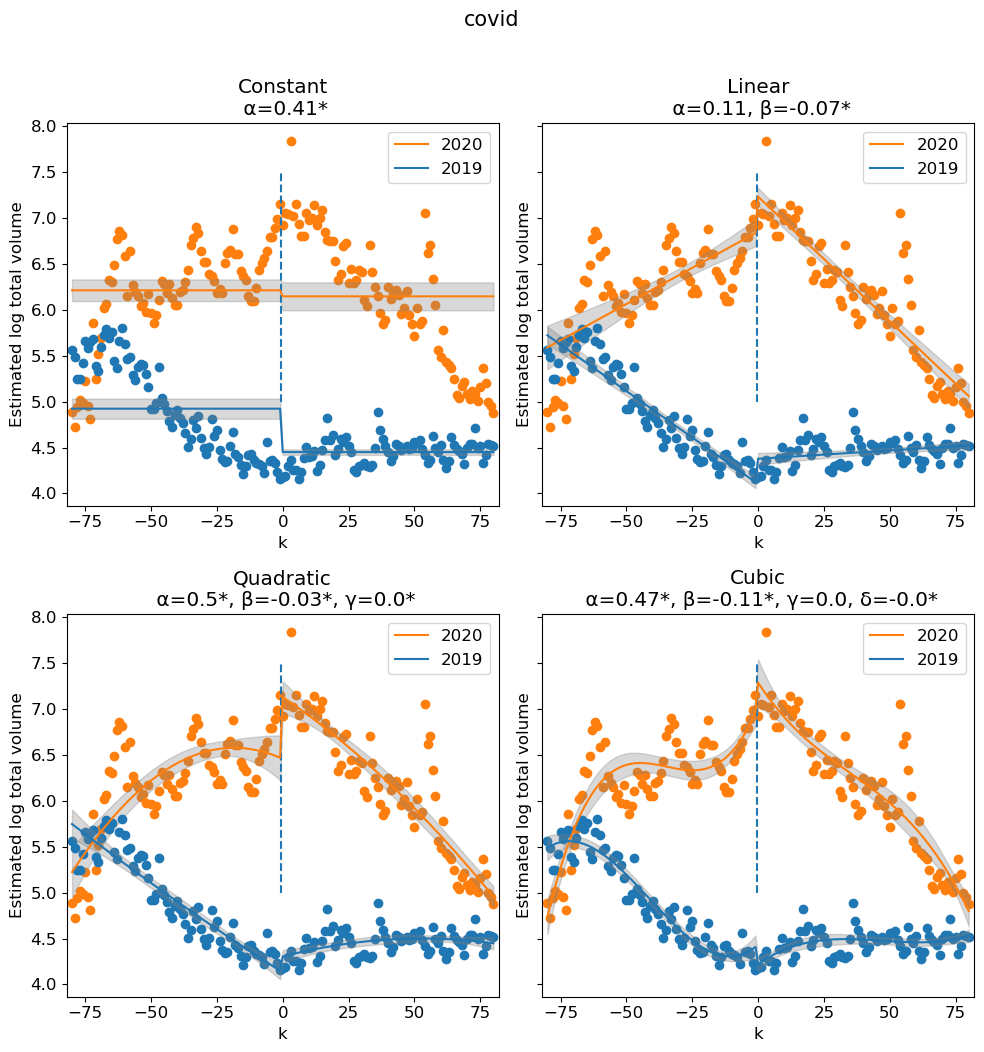

In [12]:
mpl.rcParams['font.size'] = 12
fig, axes = plt.subplots(2,2, figsize = (10,10), sharey = True)
country = country

for model in ['Constant','Linear','Quadratic','Cubic']:
    
    point = []
    conf = []
        
    k = 80
    
    df_temp = df.loc[(df['k'] >= -k) & (df['k'] <= k)].copy()

    df_temp['pageviews'] = df_temp['pageviews'].apply(np.log)

    mod = smf.ols(generate_equation(model), 
                  data = df_temp)

    res = mod.fit(cov_type='hc0')
 
    if model == 'Constant':
        sbplt = axes[0,0]
        sbplt.set_title(model+'\n α='+str(round(res.params['intervention_flag:year[T.2020]'],2))+'*' if res.pvalues['intervention_flag:year[T.2020]']<0.05 else '')
        
    elif model == 'Linear':
        sbplt = axes[0,1]
        sbplt.set_title(model+'\n α='+str(round(res.params['intervention_flag:year[T.2020]'],2))+('*' if res.pvalues['intervention_flag:year[T.2020]']<0.05 else '') +
                        ', β='+str(round(res.params['intervention_flag:k:year[T.2020]'],2)) + ('*' if res.pvalues['intervention_flag:k:year[T.2020]']<0.05 else '') )

    elif model == 'Quadratic':
        sbplt = axes[1,0]
        sbplt.set_title(model+'\n α='+str(round(res.params['intervention_flag:year[T.2020]'],2))+('*' if res.pvalues['intervention_flag:year[T.2020]']<0.05 else '')+ 
                        ', β='+str(round(res.params['intervention_flag:k:year[T.2020]'],2)) + ('*' if res.pvalues['intervention_flag:k:year[T.2020]']<0.05 else '')+
                        ', γ='+str(round(res.params['intervention_flag:np.power(k, 2):year[T.2020]'],2)) + ('*' if res.pvalues['intervention_flag:np.power(k, 2):year[T.2020]']<0.05 else ''))

    else:
        sbplt = axes[1,1]
        sbplt.set_title(model+'\n α='+str(round(res.params['intervention_flag:year[T.2020]'],2))+('*' if res.pvalues['intervention_flag:year[T.2020]']<0.05 else '')+ 
                        ', β='+str(round(res.params['intervention_flag:k:year[T.2020]'],2)) + ('*' if res.pvalues['intervention_flag:k:year[T.2020]']<0.05 else '') +
                        ', γ='+str(round(res.params['intervention_flag:np.power(k, 2):year[T.2020]'],2)) + ('*' if res.pvalues['intervention_flag:np.power(k, 2):year[T.2020]']<0.05 else '') +
                        ', δ='+str(round(res.params['intervention_flag:np.power(k, 3):year[T.2020]'],2)) + ('*' if res.pvalues['intervention_flag:np.power(k, 3):year[T.2020]']<0.05 else ''))

    
    sbplt.vlines(-0.5,5,7.5, linestyle = '--')

    df_temp = df.loc[(df['k'] >= -k) & (df['k'] <= k) & (df['year'] == '2020')].copy()

    df_temp['pageviews'] = df_temp['pageviews'].apply(np.log)
    
    sbplt.scatter(df_temp['k'].values,df_temp['pageviews'].values, color = 'tab:orange')
    sbplt.fill_between(df_temp['k'].values,res.get_prediction(df_temp).conf_int()[:,0],
                 res.get_prediction(df_temp).conf_int()[:,1], alpha = 0.3, color = 'gray')

    sbplt.plot(df_temp['k'].values,res.get_prediction(df_temp).predicted_mean, color = 'tab:orange', label = '2020')

    
    
    
    df_temp = df.loc[(df['k'] >= -k) & (df['k'] <= k) & (df['year'] == '2019')].copy()

    df_temp['pageviews'] = df_temp['pageviews'].apply(np.log)
    
    sbplt.scatter(df_temp['k'].values,df_temp['pageviews'].values, color = 'tab:blue')
    sbplt.fill_between(df_temp['k'].values,res.get_prediction(df_temp).conf_int()[:,0],
                 res.get_prediction(df_temp).conf_int()[:,1], alpha = 0.3, color = 'gray')

    sbplt.plot(df_temp['k'].values,res.get_prediction(df_temp).predicted_mean, color = 'tab:blue', label = '2019')


    sbplt.legend()

    sbplt.set_xlabel('k')

    sbplt.set_xlim([-82,82])
    #sbplt.set_xlabel('Bandwidth (± weeks around intervention)')
    sbplt.set_ylabel('Estimated log total volume')
    #sbplt.set_ylim([-1.5,2.5])

plt.tight_layout()

fig.suptitle(category, position = (0.5,1.05), fontsize= 15)

#plt.savefig(FIGURES_DIR+"example_italy_bread.pdf", bbox_inches='tight')

# Weekly data

We also tried the analysis process with weekly data, as the weekly data can reduce volatility. At the end, results are similar

In [13]:
# load pageview data 
with open('./data/keyword_pageviews_allcountry_weekly.pickle', 'rb') as handle:
    all_pageviews_w = pickle.load(handle)
# all_pageviews_w['ja']['pageviews']['noncovid'].head()

In [14]:
all_pageviews_w['fi']['pageviews']['noncovid'].head()

,Hepatitis_C,Colorectal_cancer,Ovarian_cancer,HIV_and_men_who_have_sex_with_men,Ulcerative_colitis,Type_2_diabetes,Food_allergy,Cataract,Cancer_vaccine,Seborrhoeic_dermatitis,Diabetes,Cancer_cell,World_AIDS_Day,Sepsis,Hypokalemic_periodic_paralysis,Cancer_immunotherapy,Milk_allergy,Maturity_onset_diabetes_of_the_young,Rhinitis,Alcohol_and_cancer,Appendicitis,Type_1_diabetes,Flatulence,Allergic_rhinitis,Stasis_dermatitis,Oral_cancer,Penile_cancer,Pancreatic_cancer,Abdominal_pain,Tuskegee_syphilis_experiment,Endometrial_cancer,Hypertension,Breast_cancer,Prostate_cancer,Malnutrition,Dermatitis,HIV_vaccine,Colitis,Hives,Dermatitis_herpetiformis,Gallbladder_cancer,Back_pain,Atopic_dermatitis,Anal_cancer,Rheumatoid_arthritis,Cervical_cancer,Laryngeal_cancer,Pulmonary_hypertension,Tree_nut_allergy,Testicular_cancer,Hepatitis,Varicose_veins,Lung_cancer,Hearing_loss,Bladder_cancer,Wheat_allergy,Gastroenteritis,Conjunctivitis,Osteoarthritis,Athlete's_foot,Hereditary_nonpolyposis_colorectal_cancer,Liver_cancer,Gout,Guatemala_syphilis_experiments,Thyroid_cancer,Inflammation,Systemic_lupus_erythematosus,Chickenpox,Paralysis,Skin_cancer,Dehydration,Constipation,Meningitis,Hyperhidrosis,Esophageal_cancer,Kidney_cancer,HIV,Sleep_paralysis,Bruise,Vaginal_flatulence,List_of_types_of_malnutrition,Mycobacterium_tuberculosis,Discoid_lupus_erythematosus,Tuberculosis,Allergy,Toothache,Stomach_cancer,Phytophotodermatitis,Hypothyroidism,Cancer,Asthma,Heart_cancer,Syphilis,Alcoholic_hepatitis,Autoimmune_hepatitis,Diabetes_insipidus
2019-01-06,231,232,67,0.0,280,0.0,0.0,236,2.0,60,618,38.0,0.0,444,3.0,11.0,92,0.0,91,42.0,88,0.0,553,14.0,10.0,146,80,361,64,229.0,27.0,290,119,131,19.0,287,0.0,18.0,124,107,16.0,59,156,83,306,121,75,10.0,116,160,519,87,242,102,75,101,148,211,129,123,72.0,278,342,93.0,56.0,404,520,425,136,97,229,277,488,24.0,477,81,940,1491,216,178,5.0,12.0,113,1061,172,51.0,89,0.0,451,588,226,21.0,1069,45.0,35,60
2019-01-13,360,353,91,0.0,280,0.0,0.0,394,9.0,87,1115,77.0,0.0,439,4.0,22.0,173,0.0,112,26.0,156,0.0,606,14.0,35.0,168,122,435,63,47.0,49.0,435,159,181,54.0,530,0.0,29.0,133,96,11.0,72,210,92,474,177,84,26.0,126,186,572,127,270,122,97,195,253,249,176,160,62.0,428,504,24.0,64.0,488,561,617,165,149,314,293,526,18.0,374,107,1072,1540,193,178,2.0,48.0,122,2313,297,51.0,114,0.0,523,1020,373,32.0,1268,49.0,48,93
2019-01-20,334,309,95,0.0,300,0.0,0.0,550,1.0,72,1166,75.0,0.0,430,8.0,22.0,198,0.0,162,42.0,85,0.0,694,23.0,20.0,163,133,531,70,46.0,53.0,441,175,183,42.0,252,0.0,19.0,154,87,10.0,90,206,84,454,184,85,29.0,148,200,579,172,290,208,93,192,170,234,206,149,144.0,359,399,13.0,71.0,493,595,542,188,183,387,280,441,17.0,510,87,1111,1278,224,148,0.0,57.0,157,1257,339,59.0,77,0.0,573,1002,515,45.0,1109,67.0,66,70
2019-01-27,265,384,101,0.0,254,0.0,0.0,434,14.0,87,1085,77.0,0.0,893,9.0,30.0,181,0.0,157,36.0,58,0.0,581,27.0,18.0,124,139,570,52,40.0,55.0,452,152,175,45.0,250,0.0,19.0,127,75,18.0,76,221,108,407,177,94,23.0,166,195,604,166,340,139,86,162,235,248,186,134,115.0,374,462,14.0,87.0,516,550,571,149,202,383,297,501,23.0,437,105,1050,1400,169,185,2.0,49.0,111,1211,318,59.0,326,0.0,557,1008,402,35.0,1003,171.0,91,73
2019-02-03,238,370,89,0.0,250,0.0,0.0,449,5.0,80,1009,55.0,0.0,544,10.0,28.0,193,0.0,245,31.0,60,0.0,591,24.0,24.0,150,99,3557,61,32.0,60.0,498,157,149,42.0,317,0.0,20.0,98,90,21.0,81,201,82,402,169,83,13.0,159,162,434,152,264,122,75,203,207,203,191,120,108.0,396,397,13.0,98.0,486,749,596,129,185,382,326,497,27.0,476,145,1252,1335,149,176,2.0,31.0,475,1044,313,43.0,97,0.0,510,934,410,48.0,882,53.0,90,110
